# The North Face e-commerce : boosting online sales !

In this project, you'll work with a corpus of item descriptions from an outdoor apparel brand's product catalog.
The dataset is available on Kaggle : https://www.kaggle.com/cclark/product-item-data?select=sample-data.csv


In part 1, you will use a clustering model, in order to identify groups of products that have similar descriptions.

In part2, the groups of similar products will be used to construct a very simple recommender system algorithm.

In part3, you will train a LSA model (instead of clustering) to extract topics from the corpus.

Pre-requisite : if necessary, install the required libraries for NLP (spacy, wordclouds) and download the english language model. Then, import all the libraries.

In [1]:
# Install spacy quietly
!pip install spacy -q

In [2]:
# Download english language model
!python -m spacy download en -q

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.8/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
# Install wordcloud
!pip install wordcloud

1. Import pandas, numpy, spacy, sklearn (tfidf vectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud

In [4]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Read the corpus and put it in a DataFrame named `corpus`, explore it and print the full description in the first line

In [5]:
corpus = pd.read_csv('sample-data.csv')

In [6]:
print(corpus.shape)
corpus.head()

(500, 2)


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [7]:
corpus.loc[0,'description']

'Active classic boxers - There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><b

## Text preprocessings

3. Use `str` methods to clean the texts (and check it worked with the first document). Save the clean texts into a column named `clean_description`

In [8]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
corpus.loc[0,'clean_description']

'Active classic boxers There s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations The quick drying lightweight underwear takes up minimal space in a travel pack An exposed brushed waistband offers next to skin softness five panel construction with a traditional boxer back for a classic fit and a functional fly Made of oz recycled polyester with moisture wicking performance Inseam size M is Recyclable through the Common Threads Recycling Program Details Silky Capilene fabric is ultralight breathable and quick to dry Exposed brushed elastic waistband for comfort panel construction with traditional boxer back Inseam size M is Fabric oz all recycled polyester with Gladiodor natural odor control for the garment Recyclable through the Common Threads Recycling Program Weight g oz Made in Mexico '

4. Tranform every character into lowercase (and check it worked with the first document)

In [9]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
corpus.loc[0,'clean_description']

'active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space in a travel pack an exposed brushed waistband offers next to skin softness five panel construction with a traditional boxer back for a classic fit and a functional fly made of oz recycled polyester with moisture wicking performance inseam size m is recyclable through the common threads recycling program details silky capilene fabric is ultralight breathable and quick to dry exposed brushed elastic waistband for comfort panel construction with traditional boxer back inseam size m is fabric oz all recycled polyester with gladiodor natural odor control for the garment recyclable through the common threads recycling program weight g oz made in mexico '

5. Use spacy to tokenize the documents (put the result in a new column named `clean_tokens`)

In [10]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"(active, classic, boxers, there, s, a, reason,..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"(active, sport, boxer, briefs, skinning, up, g..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"(active, sport, briefs, these, superbreathable..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"(alpine, guide, pants, skin, in, climb, ice, s..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"(alpine, wind, jkt, on, high, ridges, steep, i..."


6. Remove the stop words and lemmatize `clean_tokens`

In [11]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a..."


7. For each document, write all the cleaned tokens into one single string (and write it in a new column named `clean_document`)

In [12]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...


## Part 1 - clustering on text documents

8. Create a new numpy array X containing the TF-IDF transformation from the column `clean_document`, and then print the vocabulary of the corpus

In [13]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
X.shape

(500, 3579)

In [14]:
# Print vocabulary
vectorizer.vocabulary_

{'active': 25,
 'classic': 514,
 'boxer': 338,
 'reason': 2405,
 'cult': 727,
 'favorite': 1102,
 'cool': 649,
 'especially': 1030,
 'sticky': 2934,
 'situation': 2755,
 'quick': 2364,
 'drying': 916,
 'lightweight': 1732,
 'underwear': 3319,
 'minimal': 1905,
 'space': 2857,
 'travel': 3234,
 'pack': 2115,
 'expose': 1063,
 'brushed': 371,
 'waistband': 3433,
 'offer': 2053,
 'skin': 2766,
 'softness': 2837,
 'panel': 2134,
 'construction': 627,
 'traditional': 3217,
 'fit': 1145,
 'functional': 1251,
 'fly': 1191,
 'oz': 2112,
 'recycled': 2415,
 'polyester': 2261,
 'moisture': 1930,
 'wicke': 3509,
 'performance': 2189,
 'inseam': 1559,
 'size': 2756,
 'recyclable': 2413,
 'common': 583,
 'thread': 3153,
 'recycle': 2414,
 'program': 2317,
 'silky': 2734,
 'capilene': 424,
 'fabric': 1080,
 'ultralight': 3299,
 'breathable': 346,
 'dry': 914,
 'elastic': 962,
 'comfort': 574,
 'gladiodor': 1291,
 'natural': 1979,
 'odor': 2052,
 'control': 640,
 'garment': 1266,
 'weight': 3486,
 'm

9. Create a DataFrame containing the result from TF-IDF

In [15]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,young,yvon,zest,zinger,zip,zipper,zippered,zippers,zone,zones
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.296384,0.0,0.000000,0.0,0.0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.108619,0.0,0.074676,0.0,0.0


10. Use DBSCAN to make some clustering on the TF-IDF matrix. When dealing with texts, the distance metric to be used is "cosine" instead of "euclidean". You have to find some values for `eps` and `min_samples` that allow to get 10-20 clusters and not too many outliers

In [16]:
# Clustering on documents
# Instanciate DBSCAN 
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
## No need to normalize data, it already is! 
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,1


,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,yvon,zest,zinger,zip,zipper,zippered,zippers,zone,zones,cluster_id
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.296384,0.0,0.000000,0.0,0.0,1
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.108619,0.0,0.074676,0.0,0.0,1


11. Print number of documents in each cluster

In [17]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

 1     215
 0      72
 5      57
-1      33
 2      29
 7      24
 14     13
 4      10
 3       9
 6       8
 10      7
 12      6
 9       5
 13      4
 11      4
 8       4
Name: cluster_id, dtype: int64

12. Print a sample of 3 documents that belong to cluster 0

In [18]:
# Print sample of 3 documents from cluster 0
for d in corpus.loc[corpus['cluster_id']==0,:].sample(3)['description']:
    print(d)
    print()

Sunshade hoody - Put an end to the sunscreen standoff with this light, quick-drying hoody. It has built-in 30-UPF sun protection, and the smooth-against-the-skin 4.3-oz 100% all-recycled polyester fabric stretches, breathes, and wicks away moisture. The hood provides a refuge when the Jalama wind kicks in, and offset shoulder seams stay smooth under pack straps. A front kangaroo pocket holds shells and beach treasures. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Soft, stretchy polyester fabric is fast wicking, quick drying and breathable"</li> <li>Hood provides extra sun and wind protection</li> <li>Built-in 30-UPF sun protection</li> <li>Forward shoulder seams</li> <li>Kangaroo pocket</li></ul><br><br><b>Fabric: </b>4.3-oz 100% polyester jersey. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(178 g 6.2 oz)<br><br>Made in Vietnam.

Cap 3 crew - Jumping off rocks or over mud puddles -  kids spend as much time in

12.b. Print a sample of 3 documents that belong to each cluster

In [19]:
# Print sample of 3 documents for each cluster
for c in corpus['cluster_id'].value_counts().index :
    print("CLUSTER ", c)
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['description']:
        print(d)
        print()
    print('-----------')

CLUSTER  1
Duality jkt - Like the spring weather in Michigan's Upper Peninsula, our reversible Kid's Duality changes moods in seconds. The jacket's three-season versatility has a wind-resistant 2.3-oz 100% all-recycled polyester shell side that's treated with a Deluge DWR (durable water repellent) finish to resist wet weather; the warm, breathable 4.4-oz 100% all-recycled polyester microdenier fleece side keeps the chill out. The front zips into a neck-buffering stand-up collar, and raglan sleeves provide ample arm room. With zippered pockets, a reflective logo and a reflective zipper on the shell side; hook-and-loop-secured drop-in pockets; a reflective logo on the fleece side. Hip length. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Reverses from a water-and-wind resistant Deluge DWR (durable water repellent) treated polyester shell side to a cozy microdenier fleece side</li> <li>Stand-up collar for wind protection</li> <li>Zippered pockets 

13. Print the 5 Most frequent words in each cluster

In [20]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  1
pocket     0.093850
recycle    0.064933
organic    0.063162
cotton     0.061716
oz         0.057035
dtype: float64
-----------
CLUSTER  0
sun           0.106520
polyester     0.092838
upf           0.083425
recycle       0.082098
protection    0.077720
dtype: float64
-----------
CLUSTER  5
shirt        0.174503
ringspun     0.166558
print        0.162948
phthalate    0.161184
pvc          0.159509
dtype: float64
-----------
CLUSTER  -1
cotton     0.071810
organic    0.071810
oz         0.048809
pocket     0.047083
spandex    0.040555
dtype: float64
-----------
CLUSTER  2
pocket          0.137073
mesh            0.115422
strap           0.107557
polyurethane    0.099001
deni            0.094985
dtype: float64
-----------
CLUSTER  7
merino          0.347789
wool            0.261021
wash            0.153251
construction    0.103310
odor            0.101776
dtype: float64
-----------
CLUSTER  14
spandex      0.136142
bra          0.121837
removable    0.119366
nylon        0.118

14. Make a wordcloud for each cluster : can you see a difference between the groups ?

CLUSTER  1


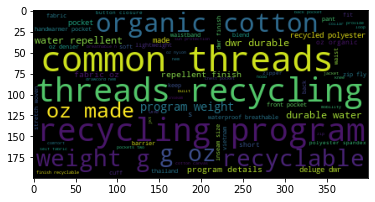

-----------
CLUSTER  0


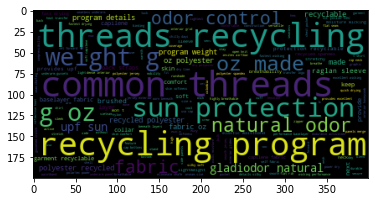

-----------
CLUSTER  5


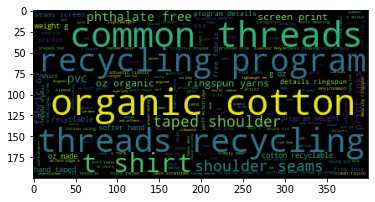

-----------
CLUSTER  -1


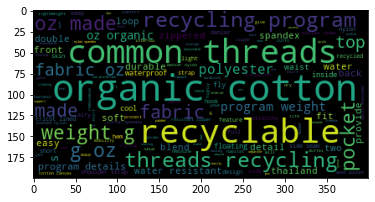

-----------
CLUSTER  2


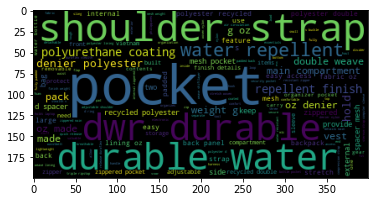

-----------
CLUSTER  7


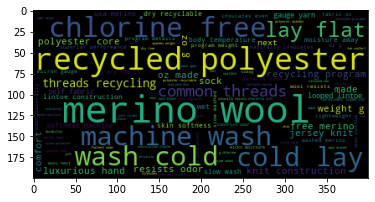

-----------
CLUSTER  14


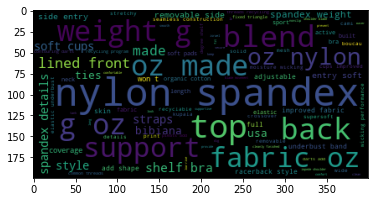

-----------
CLUSTER  4


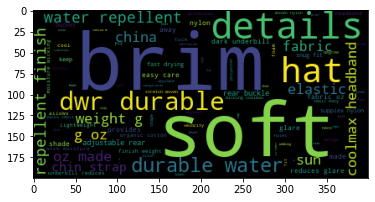

-----------
CLUSTER  3


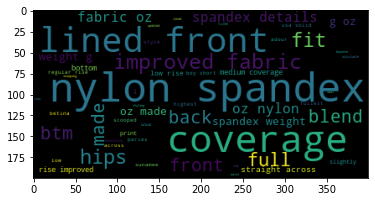

-----------
CLUSTER  6


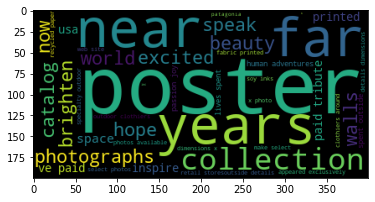

-----------
CLUSTER  10


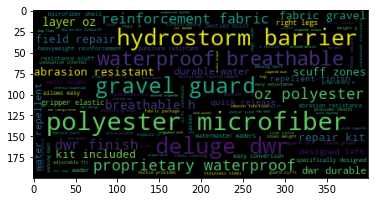

-----------
CLUSTER  12


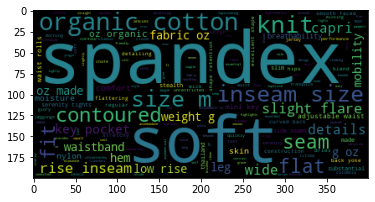

-----------
CLUSTER  9


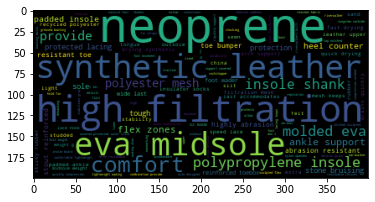

-----------
CLUSTER  13


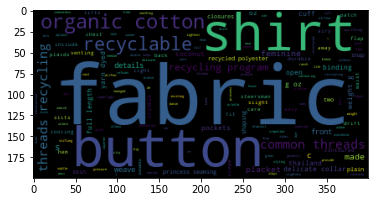

-----------
CLUSTER  11


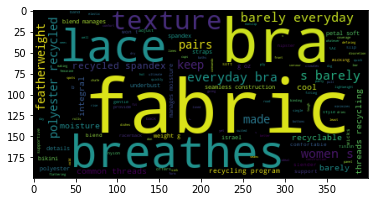

-----------
CLUSTER  8


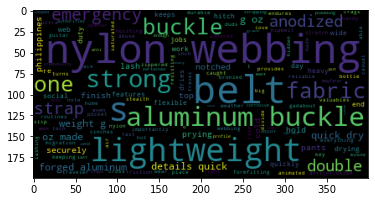

-----------


In [21]:
# Word cloud for each cluster
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 2 - Recommender system

Now, we will use the cluster ids from part 1 to build a recommender system. The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we will consider that products belonging to the same cluster are similar.

15. Create a function named `find_similar_items` that takes an argument `item_id` representing the id of a product, and that returns a list of 5 item ids that belong to the same cluster as the product passed in argument

In [22]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,1


In [23]:
def find_similar_items(item_id):
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items.sample(5)['id'].unique()
    return similar_item_ids

16. Use python's `input()` function to allow the user to choose a product and perform some suggestions of similar items

In [24]:
product_id = int(input("What product would you like to buy ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print('Product found in database, description below : ')
    print(item_desc)
    print()
    
    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print('Item #', i)
        print(corpus.loc[corpus['id']==i, 'description'].values[0])
        print('--------------------')

What product would you like to buy ?  4



Product found in database, description below : 
Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mountain endeavor. The midweight stretch-woven polyester won't restrict your moves, and the brushed interior maintains next-to-skin comfort. A 2-way zippered fly keeps things easy with a harness on, and the gusseted, zippered cuffs have 2-position snaps and tie-down loops. With water-resistant zippered pockets: two front, two thigh, one back hip. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Durable stretch-woven polyester (47% recycled) with DWR (durable water repellent) finish is water- and wind-resistant and highly breathable</li> <li>Brushed interior for next-to-skin comfort</li> <li>Waistband has belt loops and elastic on back</li> <li>2-way zippered fly</li> <li>"External pockets: two front slash, tw

## Part 3 - LSA for topic extraction

17. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix. You can try values for `n_components` and that allow to get 10-20 clusters. Save the encoded matrix into a variable named `topic_encoded_df`

In [25]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.258892,-0.042789,0.170607,0.097877,-0.108126,0.021663,-0.077952,0.002239,-0.107902,-0.022689,0.013688,0.020526,active classic boxers there s a reason why our...
1,0.298290,-0.052721,0.099568,0.108462,-0.023279,0.144617,-0.018348,-0.012981,-0.110490,-0.101396,-0.016632,-0.040665,active sport boxer briefs skinning up glory re...
2,0.287659,-0.079383,0.103528,0.029478,-0.031287,0.129417,0.093217,0.062452,-0.065186,-0.032789,-0.011549,-0.112170,active sport briefs these superbreathable no f...
3,0.414784,-0.268201,-0.115953,-0.156317,0.040242,-0.024274,-0.059828,-0.123108,-0.041636,-0.135200,0.009130,0.086610,alpine guide pants skin in climb ice switch to...
4,0.389376,-0.266605,-0.015727,-0.245582,-0.036587,-0.059890,0.038446,-0.010270,0.065317,-0.166139,0.019618,0.231450,alpine wind jkt on high ridges steep ice and a...


Contrary to clustering, LSA allows to map each document to a mixing of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, let's extract the main topic of each document.

18. What is the main topic related to document 0 ?

In [26]:
topics_doc0 = np.abs(topic_encoded_df.iloc[0,:-1])
main_topic = topics_doc0.sort_values(ascending=False).index[0]
print(main_topic)

topic_0


19. Create a new column named `main_topic` in `topic_encoded_df` where you will store the main topics related to each document

In [27]:
def extract_main_topics(x):
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column `main_topics` with NANs
topic_encoded_df.loc[:, 'main_topic'] = np.nan

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.258892,-0.042789,0.170607,0.097877,-0.108126,0.021663,-0.077952,0.002239,-0.107902,-0.022689,0.013688,0.020526,active classic boxers there s a reason why our...,topic_0
1,0.298290,-0.052721,0.099568,0.108462,-0.023279,0.144617,-0.018348,-0.012981,-0.110490,-0.101396,-0.016632,-0.040665,active sport boxer briefs skinning up glory re...,topic_0
2,0.287659,-0.079383,0.103528,0.029478,-0.031287,0.129417,0.093217,0.062452,-0.065186,-0.032789,-0.011549,-0.112170,active sport briefs these superbreathable no f...,topic_0
3,0.414784,-0.268201,-0.115953,-0.156317,0.040242,-0.024274,-0.059828,-0.123108,-0.041636,-0.135200,0.009130,0.086610,alpine guide pants skin in climb ice switch to...,topic_0
4,0.389376,-0.266605,-0.015727,-0.245582,-0.036587,-0.059890,0.038446,-0.010270,0.065317,-0.166139,0.019618,0.231450,alpine wind jkt on high ridges steep ice and a...,topic_0


20. What is the count of each main topic in the corpus ?
What is the most represented topic in the corpus?

In [28]:
topic_encoded_df['main_topic'].value_counts()

topic_0     264
topic_1      61
topic_6      37
topic_2      35
topic_7      30
topic_3      19
topic_4      13
topic_11     11
topic_8       8
topic_10      8
topic_9       7
topic_5       7
Name: main_topic, dtype: int64

--> Here, topic_0 is the most represented topic, as it's the main topic for 275 documents of the corpus.

15. Use the attribute `components_` of your SVD model to print the 5 most important words in each topic

In [29]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

topics_description.head()

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,young,yvon,zest,zinger,zip,zipper,zippered,zippers,zone,zones
topic_0,0.001093,0.002232,0.000390,0.019024,0.000787,0.000893,0.000893,0.001192,0.001319,0.001334,...,0.000674,0.001546,0.001126,0.000614,0.089621,0.102481,0.049830,0.006719,0.005494,0.001884
topic_1,0.000468,0.000817,0.000408,0.023102,0.000691,0.000877,0.000621,0.001734,0.001440,0.003814,...,0.000483,0.004725,0.001480,0.000847,0.059682,0.121308,0.055642,0.009663,0.007628,0.003234
topic_2,0.003379,0.005973,0.000065,0.018337,0.000097,0.000089,0.002130,0.001078,0.000532,0.000546,...,0.000315,0.000690,0.000328,0.000778,0.070365,0.060387,0.041074,0.005974,0.002067,0.002436
topic_3,0.000621,0.000276,0.000074,0.012859,0.000811,0.002039,0.000233,0.003253,0.000150,0.002143,...,0.001131,0.003276,0.002808,0.000833,0.076245,0.132625,0.043192,0.015554,0.011318,0.006168
topic_4,0.004126,0.009284,0.000691,0.017551,0.000854,0.000304,0.001708,0.000741,0.000376,0.000067,...,0.000108,0.000540,0.000549,0.000409,0.012219,0.005006,0.009681,0.004994,0.016531,0.003395


In [30]:
# Loop over each topic and print 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC ', i)
    
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    
    print()
    print('-------------------------')
    print()

TOPIC  topic_0
['recycle', 'pocket', 'oz', 'organic', 'cotton']

-------------------------

TOPIC  topic_1
['organic', 'cotton', 'shirt', 'print', 'ringspun']

-------------------------

TOPIC  topic_2
['merino', 'odor', 'pocket', 'wool', 'control']

-------------------------

TOPIC  topic_3
['inseam', 'organic', 'cotton', 'button', 'short']

-------------------------

TOPIC  topic_4
['merino', 'wool', 'wash', 'sun', 'capilene']

-------------------------

TOPIC  topic_5
['nylon', 'sun', 'organic', 'cotton', 'fleece']

-------------------------

TOPIC  topic_6
['spandex', 'coverage', 'tencel', 'inseam', 'pocket']

-------------------------

TOPIC  topic_7
['strap', 'mesh', 'waterproof', 'polyurethane', 'barrier']

-------------------------

TOPIC  topic_8
['sun', 'upf', 'protection', 'collar', 'recycled']

-------------------------

TOPIC  topic_9
['fleece', 'waterproof', 'barrier', 'sun', 'organic']

-------------------------

TOPIC  topic_10
['photo', 'poster', 'outside', 'passion', 

16. Make a wordcloud describing each topic. Do you notice disrepancies with the wordclouds describing the clusters (part2) ?

In [31]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.258892,-0.042789,0.170607,0.097877,-0.108126,0.021663,-0.077952,0.002239,-0.107902,-0.022689,0.013688,0.020526,active classic boxers there s a reason why our...,topic_0
1,0.298290,-0.052721,0.099568,0.108462,-0.023279,0.144617,-0.018348,-0.012981,-0.110490,-0.101396,-0.016632,-0.040665,active sport boxer briefs skinning up glory re...,topic_0
2,0.287659,-0.079383,0.103528,0.029478,-0.031287,0.129417,0.093217,0.062452,-0.065186,-0.032789,-0.011549,-0.112170,active sport briefs these superbreathable no f...,topic_0
3,0.414784,-0.268201,-0.115953,-0.156317,0.040242,-0.024274,-0.059828,-0.123108,-0.041636,-0.135200,0.009130,0.086610,alpine guide pants skin in climb ice switch to...,topic_0
4,0.389376,-0.266605,-0.015727,-0.245582,-0.036587,-0.059890,0.038446,-0.010270,0.065317,-0.166139,0.019618,0.231450,alpine wind jkt on high ridges steep ice and a...,topic_0


-------------------------

TOPIC  topic_0


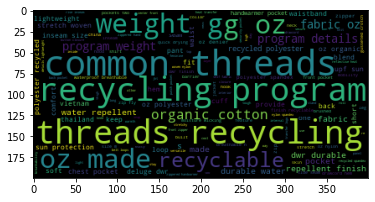


-------------------------

TOPIC  topic_1


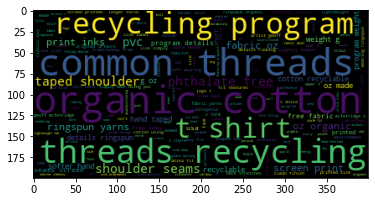


-------------------------

TOPIC  topic_2


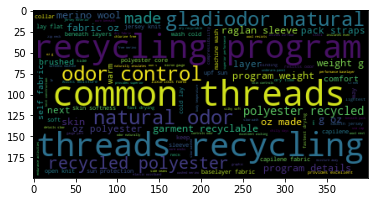


-------------------------

TOPIC  topic_3


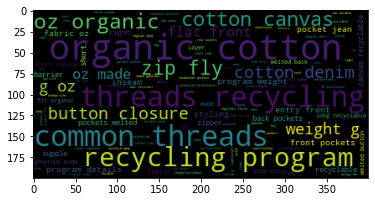


-------------------------

TOPIC  topic_4


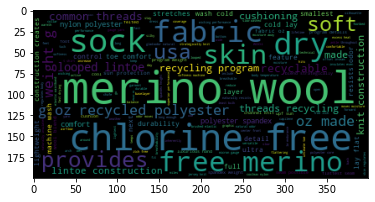


-------------------------

TOPIC  topic_5


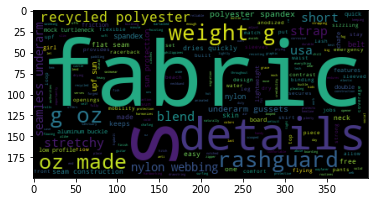


-------------------------

TOPIC  topic_6


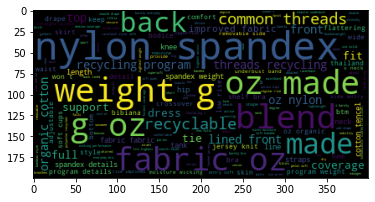


-------------------------

TOPIC  topic_7


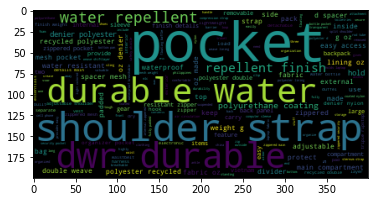


-------------------------

TOPIC  topic_8


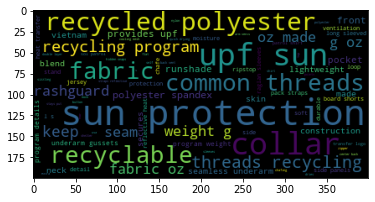


-------------------------

TOPIC  topic_9


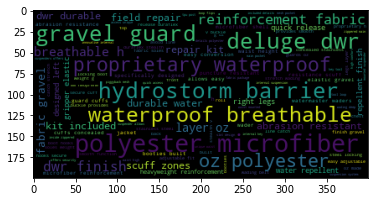


-------------------------

TOPIC  topic_10


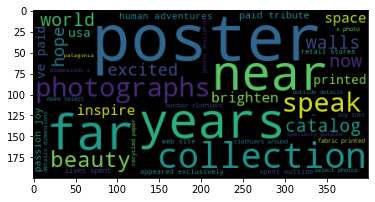


-------------------------

TOPIC  topic_11


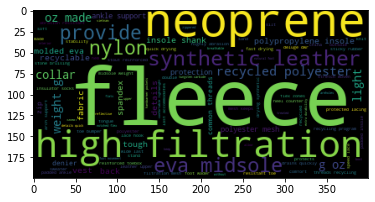

In [32]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

--> It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to merino wool).

The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.